# Mix

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage 

import os
import cv2

import pandas as pd
%matplotlib inline

In [2]:
# Load images and resize 
root= './train'

def load_data(root_path):
    names = []
    train_crude = []

    for file in os.listdir(root_path):
        img = cv2.imread(os.path.join(root_path, file))#,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img.shape[1]//3,img.shape[0]//3))
        train_crude.append(img)
        names.append(file.split('.')[0])
    
    data = np.stack( train_crude, axis=0 )
    return names, data

names, data = load_data(root)

In [3]:
data.shape

(7500, 163, 226, 3)

## Extract feature CNN

In [4]:
from tensorflow.keras.applications.efficientnet import preprocess_input#, xception.decode_predictions
from tensorflow.keras.applications.efficientnet import EfficientNetB5
base_model = EfficientNetB5(weights='imagenet',input_shape=[163, 226,3],include_top=False, pooling= 'avg')

In [5]:
#get features in batches and flatten

def generate_features(data, base_model, test = False):
    feat = []
    batch_size = 500
    num_samples = data.shape[0]
    if test:
        batch_size = 10
    for i in range(0,num_samples,batch_size):
        temp = base_model.predict(preprocess_input(data[i:i + batch_size]))
        feat.append(temp)


    feat0 = np.concatenate(feat, axis = 0) 
    feat2 = [i.ravel() for i in feat0]
    feat2 = np.stack(feat2, axis = 0) #these are the features
    
    return feat2

## Nearest neighbor

In [46]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

def get_nearest_neighbours(train, validation, k = 10):
    
    #scaler = MinMaxScaler()
    neighTest = NearestNeighbors(n_neighbors = k)
    neighbors = None    
    #train = scaler.fit_transform(train)
    #validation = scaler.transform(validation)

    neighTest.fit(train)
    neighbors = neighTest.kneighbors(validation)
    
    return neighbors


## SIFT extraction for neighbor

In [7]:
#Generates de key points and descriptors of the neighbours of the images to be predicted

def generate_descriptors_neighbours(train, neighbors):
    sift = cv2.SIFT_create()

    key_points = []
    descriptors = []
    for i, i_n in enumerate(neighbors[1]): #Iterate over indices of the predicted nearest neighbours
        # print(i_n)
        kp_neighbours = []
        desc_neighbours = []
        for neigh in i_n: # Iterates over the indices of the k nearest neighbours of the instance being predicted
            img = train[neigh]
            #gray_neighbour = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)# A neighbour of the instances being predicted
            kp, des = sift.detectAndCompute(img,None) # key points and descriptors of the neighbour of instance being predicted
            kp_neighbours.append(kp)
            desc_neighbours.append(des)

        key_points.append(kp_neighbours)
        descriptors.append(desc_neighbours)
    
    return key_points, descriptors


#Generates de key points and descriptors of the images to be predicted

def generate_descriptors(valid_data):
    sift = cv2.SIFT_create()
    
    key_points = []
    descript = []

    for img in valid_data: #Iterate over indices of predictions
        # print(i_n)
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(img,None) # key points and descriptors of the instance being predicted
        key_points.append(kp)
        descript.append(des)
    
    return key_points, descript



In [47]:
train_img, validation_img = data[:7000], data[7000:]

feat = generate_features(data, base_model)
train_feat, validation_feat = feat[:7000], feat[7000:]

neighbors = get_nearest_neighbours(train_feat, validation_feat, 12)

kpts_target, descriptors_target = generate_descriptors(validation_img)
kpts_cand, descriptors_cand = generate_descriptors_neighbours(train_img, neighbors)

In [9]:
#len(descriptors_target)
len(descriptors_target[0][0])

128

In [45]:
def find_matches(matcher,kp1, des1, kp2, des2):
    # Matching descriptor using KNN algorithm
    try:
        matches = matcher.knnMatch(des1, des2, k = 2)
    except:
        #print('exception in find matches')
        return None, None, None

    # Store all good matches as per Lowe's Ratio test.
    ratio = 0.5
    num_matches = 0
    ptsL = []
    ptsR = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            num_matches += 1
            ptsL.append(kp1[m.queryIdx].pt)
            ptsR.append(kp2[m.trainIdx].pt)
            
    ptsL = np.int32(ptsL)
    ptsR = np.int32(ptsR)
    
    return num_matches, ptsL, ptsR


def match(kpts_target, desc_targets, kpts_cand, desc_candidates, neighbors):
    """Finds the neighbours that best match the target image based on their descriptors

    Keyword arguments:
    kpts_target -- list of key points from the target images 
    desc_targets -- list of descriptors from the target images 
    kpts_candidates -- list (of lists) of key points from the nearest neighbours of the target images
    desc_candidates -- list (of lists) of descriptors from the nearest neighbours of the target images
    predictions = tuple containing two matrices. The first one with the distance from the nearest neighbours to the target images. 
                                                The second one with the indices of the nearest neighbours from the target images.
    Returns a matrix of matrices. Dim 0 corresponds to a matrix containing information relative to the neighbours of the target image.
                                The matrix is of shape (number of neighbours matched ,3) where the first column is the index of the neighbour in the coordinates file,
                                Second column indicates the number of matches of that neighbour with the target image
                                Third column is an object of class ptsWrapper that contains the list of matched  key points of that neighbour with the target image (use get_points() to access them) 
    """
    
    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    
    best_neighbours_matched = []
    for i, target in enumerate(desc_targets):

        matches_list = []
        ind_neighbour = []
        target_pts_list = []
        cand_pts_list = []
        for j, candidate in enumerate(desc_candidates[i]):
            #print(j)
            if candidate is not None:
                #print('neighb {}'.format(j))
                n_matches, pts_T, pts_C = find_matches(flann, kpts_target[i], target,  kpts_cand[i][j], candidate)
                #print('match completo')
                if n_matches is not None:
                    ind_neighbour.append(neighbors[1][i][j]) #Appends index in the data of the neighbour from the image being predicted
                    matches_list.append(n_matches) #Appends matches between the current neighbour and the instance being predicted
                    target_pts_list.append({'pts':pts_T})
                    cand_pts_list.append({'pts':pts_C})
                else:
                    ind_neighbour.append(neighbors[1][i][j]) #Appends index in the data of the neighbour from the image being predicted
                    matches_list.append(0) #Appends matches between the current neighbour and the instance being predicted
                    target_pts_list.append({})
                    cand_pts_list.append({})

        neighb_matches = np.stack([ind_neighbour, matches_list, target_pts_list, cand_pts_list], axis = 1) #Creates numpy array. Rows are descriptors of different neighbours. 
                                                                     # First column is index in the data, Second column is how many matches that neighbour has with the current instance
        neighb_matches = neighb_matches[neighb_matches[:, 1].argsort()[::-1][:len(matches_list)]]  #Sorts array in descending order, more matches on top and less matches at the bottom :5 is the number of neighbours
        best_neighbours_matched.append(neighb_matches)
    
    return best_neighbours_matched

In [48]:
                                 
k_best_matches = match(kpts_target, descriptors_target, kpts_cand, descriptors_cand, neighbors)

In [49]:
k_best_matches[0][0][2]['pts']

array([[  3, 109],
       [ 47,  80],
       [ 50,  78],
       [ 50,  78],
       [ 98,  78],
       [ 98,  78]])

## Get Essential matrix

In [12]:
def camera_matrix(horizontal, vertical, img):
    x = img.shape[1] / 2
    y = img.shape[0] / 2
    f_x = (x / np.tan(horizontal * (np.pi/180)/2)) 
    f_y = (y / np.tan(vertical * (np.pi/180)/2))
    return np.array([[f_x,0,x],
                     [0,f_y,y],
                     [0, 0, 1]])

K = camera_matrix(73.7, 53.1, data[0])

In [13]:
# Evaluate matches
cnt = 0
lenghtF = []
lenghtNone = []
for match in k_best_matches:
    if len(match) > 0:
        i = match[0]
        if i[1] > 1:
            ptL = i[2]['pts']
            ptR = i[3]['pts']
            E, mask = cv2.findEssentialMat(ptL, ptR, cameraMatrix = K,
                                   method=cv2.RANSAC, prob=0.999, threshold=3.0 / K[0,0])
            #F, mask = cv2.findEssentialMat(ptL,ptR,cv2.FM_RANSAC)
            if E is None:
                cnt += 1
                lenghtNone.append(i[1])
            else:
                lenghtF.append(i[1])

In [14]:
print('Fail to get E: ',cnt, ' out of 500')
print('# matches success: ', min(lenghtF), max(lenghtF), np.mean(lenghtF))
print('# mathces fail: ', min(lenghtNone), max(lenghtNone), np.mean(lenghtNone))

Fail to get E:  98  out of 500
# matches success:  5 89 15.150862068965518
# mathces fail:  2 4 2.7653061224489797


<AxesSubplot:ylabel='Frequency'>

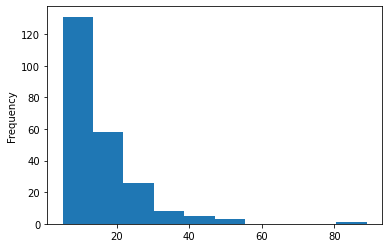

In [15]:
pd.Series(lenghtF).plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

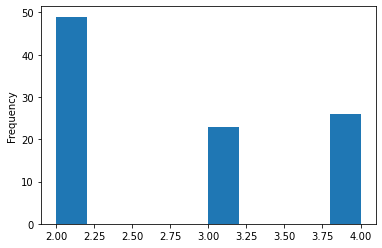

In [16]:
pd.Series(lenghtNone).plot(kind = 'hist')

### Estimate Essential matrix and predict

In [17]:
df = pd.read_csv('train.csv')

In [18]:
def estimatePose(ptT, ptC, K, cand_coor):
    
    pts_T_norm, pts_C_norm = np.ascontiguousarray(ptT, np.float32), np.ascontiguousarray(ptC, np.float32)
    #pts_T_norm = cv2.undistortPoints(np.expand_dims(pts_T_norm, axis=1), cameraMatrix=K, distCoeffs=None)
    #pts_C_norm = cv2.undistortPoints(np.expand_dims(pts_C_norm, axis=1), cameraMatrix=K, distCoeffs=None)
    try:
        E, mask = cv2.findEssentialMat(pts_C_norm, pts_T_norm, cameraMatrix = K,
                                   method = cv2.RANSAC, prob=0.999, threshold = 3.0 / K[0,0])
        points, R_est, t_est, mask_pose = cv2.recoverPose(E, pts_C_norm, pts_T_norm)
        
        return (t_est.T @ R_est)[0] + cand_coor
        #return (np.linalg.inv(R_est) @ t_est).T[0] + candi
        #translate =  t_est.T + cand_coor
        #rotate = R_est @ cand_coor.T
        #translate = t_est.T + rotate
        #return translate[0]
    except Exception as e:
        #print(e)
        return cand_coor

In [50]:
#predict neirest neigbor if E cannot be found
def predict(k_best_matches, df, K, neighbors):
    predictions = np.array([[0,0]])
    ignoreList = []
    for ix,match in enumerate(k_best_matches):


        #at least one match and more than 1 pt
        if len(match) > 0 and match[0][1] > 1:
            i = match[0]    
            ptT = i[2]['pts']
            ptC = i[3]['pts']
            cand_coor = df[['x','y']].iloc[i[0]].to_numpy()
            cand_coor = np.append(cand_coor, 1) # add  z dimension 
            pred = estimatePose(ptT, ptC, K, cand_coor) 
            pred = np.delete(pred, 2, 0)# remove z dimension

            predictions = np.append(predictions,pred.reshape(1,2),axis=0) 
        else:
            ignoreList = [ix]
            cand_coor = df[['x','y']].iloc[neighbors[1][ix][0]].to_numpy()
            predictions = np.append(predictions,cand_coor.reshape(1,2), axis=0)

    predictions = np.delete(predictions, 0, 0) 
    
    return predictions

predictions = predict(k_best_matches, df, K, neighbors)

In [ ]:
#y_true = [p for ix,p in enumerate(y_true) if not ix in ignoreList]
#pred = [p for ix,p in enumerate(predictions) if not ix in ignoreList]

### Evaluation

In [51]:
y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictions, multioutput = 'uniform_average')

13.276999133513803

In [52]:
predTest = [df[['x','y']].iloc[m[0][0]].to_numpy() if len(m) > 0 and m[0][1] > 1 else np.array([df.x.mean(), df.y.mean()]) for m in k_best_matches]
predTest = np.array(predTest)

mean_absolute_error(y_true, predTest, multioutput = 'uniform_average')

18.754795867212785

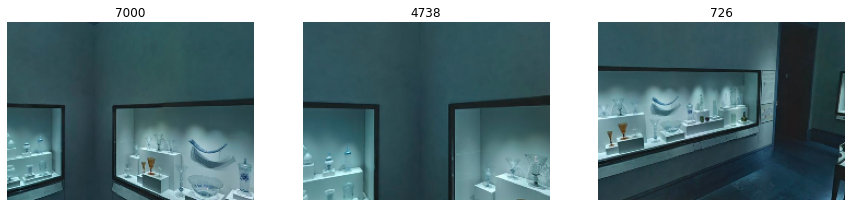

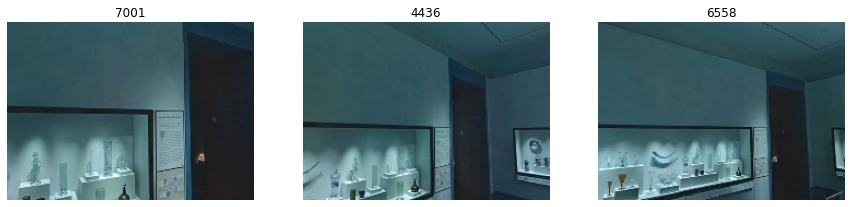

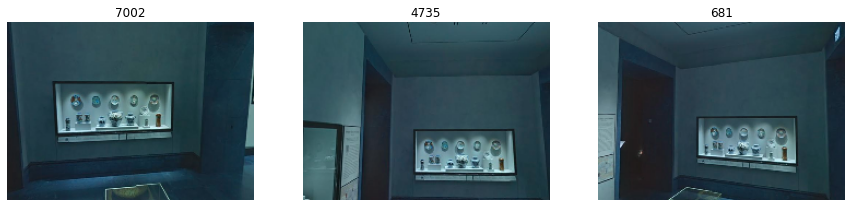

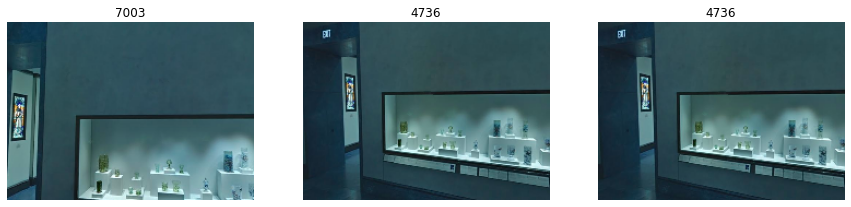

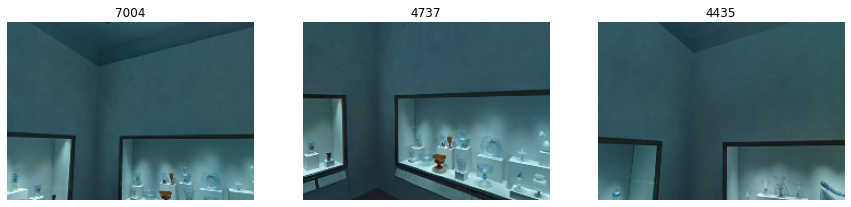

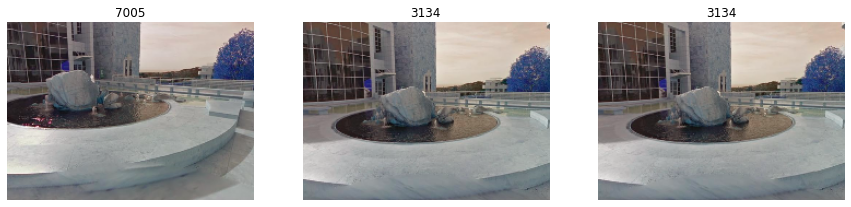

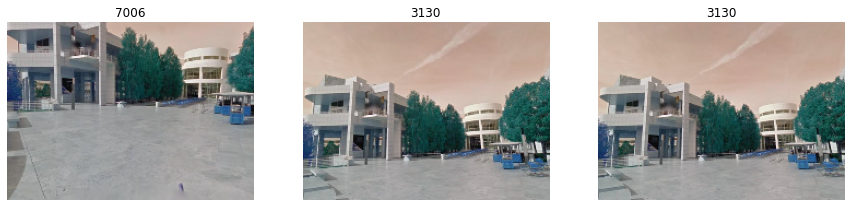

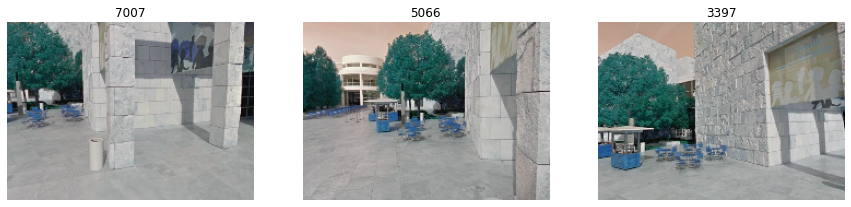

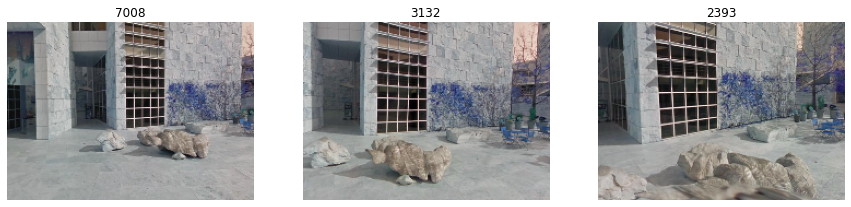

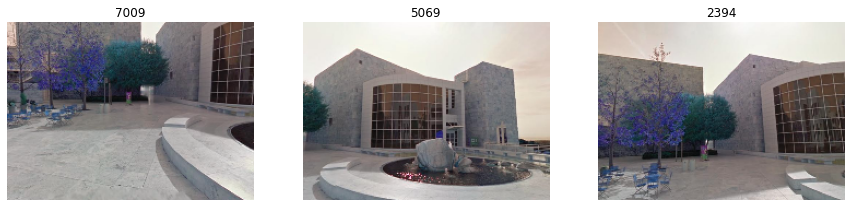

In [24]:
rng = 10
for i in range(rng):
    plt.subplots(figsize=(15,15))
    targett = data[i+7000]
    ind = k_best_matches[i][0][0]
    candidate = data[ind]
    n = neighbors[1][i][0]
    neigh = data[n]
    
    plt.subplot(1,3,1)
    plt.imshow(targett, cmap='gray') 
    plt.title(i+7000)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(candidate, cmap='gray')
    plt.title(ind)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(neigh, cmap='gray')  
    plt.title(n)
    plt.axis('off')
plt.show()

#### R and t Experimentation

In [151]:
ptT = k_best_matches[0][0][2]['pts']
ptC = k_best_matches[0][0][3]['pts']
pts_T_norm, pts_C_norm = np.ascontiguousarray(ptT, np.float32), np.ascontiguousarray(ptC, np.float32)
#pts_T_norm = cv2.undistortPoints(np.expand_dims(ptsT, axis=1), cameraMatrix=K, distCoeffs=None)
#pts_C_norm = cv2.undistortPoints(np.expand_dims(ptsC, axis=1), cameraMatrix=K, distCoeffs=None)
E, mask = cv2.findEssentialMat(pts_C_norm, pts_T_norm, cameraMatrix = K,
                           method=cv2.RANSAC, prob=0.999, threshold= .3)#3.0 / K[0,0])
points, R_est, t_est, mask_pose = cv2.recoverPose(E, pts_C_norm, pts_T_norm)

In [152]:
candi

array([15.71932192, 30.78271965,  1.        ])

In [153]:
R_est @ candi + t_est.T

array([[-15.66532941,  23.94018235,  18.16646616]])

In [179]:
(np.linalg.inv(R_est) @ t_est).T[0] + candi

array([14.83064532, 30.44488679,  1.31003688])

In [189]:
R_est @ candi + t_est.T

array([[ 16.54535356, -23.92789172, -19.96240781]])

In [179]:
target

array([14.21932192, 30.88271965,  1.        ])

In [190]:
zz = R_est @ candi.T
t_est.T + zz

array([[-15.66532941,  23.94018235,  18.16646616]])

In [191]:
zz = t_est.T + candi
R_est @ zz.T

array([[-15.76939425],
       [ 23.69399886],
       [ 19.97521749]])

In [192]:
candi.T #+ (R_est @ t_est)

array([15.71932192, 30.78271965,  1.        ])

In [193]:
R_est @ candi + t_est.T

array([[-15.66532941,  23.94018235,  18.16646616]])

In [39]:
# candidate pos
candi = df[['x','y']].iloc[k_best_matches[0][0][0]].to_numpy()
candi = np.insert(candi, 2, 1)
df.iloc[k_best_matches[0][0][0]]

id    IMG3691_4
x     15.719322
y      30.78272
Name: 4738, dtype: object

In [40]:
# ground truth
target = df[['x','y']].iloc[7000].to_numpy()
target = np.insert(target, 2, 1)

df.iloc[7000]


id    IMG4144_1
x     14.219322
y      30.88272
Name: 7000, dtype: object

In [41]:
def poseRt(R, t):
    ret = np.eye(4)
    ret[:3, :3] = R
    ret[:3, 3] = t
    return ret   
def inv_T(T):
    ret = np.eye(4)
    R_T = T[:3,:3].T
    t   = T[:3,3]
    ret[:3, :3] = R_T
    ret[:3, 3] = -R_T @ t
    return ret  

In [59]:
E

array([[-0.20275158,  0.59764312,  0.07006553],
       [ 0.23337347, -0.00134161,  0.66746995],
       [-0.09775261,  0.29284019,  0.03890048]])

In [55]:
R_est

array([[-0.68654511, -0.14949181, -0.71155323],
       [-0.32376862,  0.93911035,  0.11508971],
       [ 0.65102203,  0.30939288, -0.69314238]])

In [198]:
p = poseRt(R_est, t_est.T)
p = inv_T(p)

In [199]:
p

array([[-0.68654511, -0.32376862,  0.65102203,  0.8886766 ],
       [-0.14949181,  0.93911035,  0.30939288,  0.33783286],
       [-0.71155323,  0.11508971, -0.69314238, -0.31003688],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [51]:
M_r = np.hstack((R_est, t_est))
M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))

P_l = np.dot(K,  M_l)
P_r = np.dot(K,  M_r)
point_4d_hom = cv2.triangulatePoints(P_l, P_r, np.expand_dims(ptT, axis=1), np.expand_dims(ptC, axis=1))
point_4d = point_4d_hom / np.tile(point_4d_hom[-1, :], (4, 1))
point_3d = point_4d[:3, :].T

In [52]:
point_3d

array([[-1.75951922, -1.75951922,  5.571176  ],
       [-0.99398701, -0.99398701, -0.99405308],
       [-1.75951922, -1.75951922,  5.571176  ],
       [-0.99398701, -0.99398701, -0.99405308],
       [ 0.42336593,  0.08559969, -0.12160589],
       [-0.99422612, -0.99473356, -0.99455224]])

## TEST predictions

In [53]:
names_test, test = load_data('./test')
test_feat = generate_features(test, base_model)
neighborsT = get_nearest_neighbours(feat, test_feat)

kpts_targetT, descriptors_targetT = generate_descriptors(test)
kpts_candT, descriptors_candT = generate_descriptors_neighbours(data, neighborsT)
k_best_matchesT = match(kpts_targetT, descriptors_targetT, kpts_candT, descriptors_candT, neighborsT)
results = predict(k_best_matchesT, df, K, neighborsT)

In [44]:
df_test = pd.read_csv('imagenames.csv')
df_test = pd.concat([df_test,pd.DataFrame(results, columns=['x','y'])], axis=1)
df_test.to_csv('siftPredition', index=False)

##### OLD

In [63]:
root= './test'
names_test, test_img = load_data(root)


In [64]:
test_feat=generate_features(test_img,base_model, test=True)

In [68]:
test_feat.shape

(1200, 98304)

In [69]:
predicted_neigh = get_nearest_neighbours(feat, test_feat)

In [70]:
kps_neigh, descript_neigh = generate_descriptors_neighbours(predicted_neigh)

In [71]:
kps_target, descript_target=generate_descriptors(test_img)

In [ ]:
k_best_matches_test=match(kps_target, descript_target, kps_neigh, descript_neigh,predicted_neigh)

In [119]:


def give_preds(k_best_matches_test,predicted_neigh, df_coordinates,names_test):
    """Peforms the prediction for the test_set using the k best matches or the best neighbours in case there are no matches produced by SIFT

    Keyword arguments:
    k_best_matches_test -- k best matches list generated by feature matching using SIFT
    predicted_neigh -- predicted k nearest neighbours by the pre-trained model
    df_coordinates -- dataframe where the coordinates of the training points are
    names_test =
    """
    pred_coordinates=[]
    record_no_matches=[]
    for i, best in enumerate(k_best_matches_test):
        if best.size != 0:
            index_best=best[0][0] # This is the index of the neighbour with more matches
            pred_coordinates.append([names_test[i],df_coordinates.loc[index_best,'x'],df_coordinates.loc[index_best,'y']])
        else:
            # if there were no matches, use the average of the locations of the neighbours found by the pre-trained model
            num_neighbors=2
            x_coord_arr=np.array([df_coordinates.loc[j,'x'] for j in predicted_neigh[1][i]])
            x_coord=x_coord_arr[:num_neighbors].mean()
            y_coord_arr=np.array([df_coordinates.loc[j,'y'] for j in predicted_neigh[1][i]])
            y_coord=y_coord_arr[:num_neighbors].mean()
            pred_coordinates.append([names_test[i], x_coord, y_coord])
    
    array_preds=np.stack(pred_coordinates, axis=0)
   
    df_predictions=pd.DataFrame(array_preds, columns=['id','x','y'])
    return df_predictions

#Load the coordinates data set
coordinates = pd.read_csv('train.csv')
            
df_preds = give_preds(k_best_matches_test, predicted_neigh, coordinates,names_test)
        
    
    

In [120]:
df_preds.to_csv('resnet_knn_sift2.csv',index=False)

In [117]:
predicted_neigh

def transform predicted(predictions):

(array([[323.00092, 396.38666, 405.2545 , 406.16324, 406.93503],
        [402.14273, 403.9036 , 405.39566, 410.11633, 415.00497],
        [404.2133 , 407.3134 , 407.66003, 410.6764 , 412.31476],
        ...,
        [523.98206, 528.6266 , 529.6274 , 531.1956 , 531.5879 ],
        [431.3342 , 439.16223, 439.67752, 441.6945 , 441.93524],
        [375.47748, 380.55112, 382.6583 , 385.34314, 385.38266]],
       dtype=float32),
 array([[3158, 7050, 5008, 6206,  290],
        [3338, 1605, 6744, 7364, 2334],
        [2334, 4004, 6860, 3020, 1961],
        ...,
        [2334, 3020, 5285, 6414, 1961],
        [2334, 2433, 4543, 4008, 6949],
        [2334, 2433,  322, 2849, 3809]], dtype=int64))